In [1]:
import tensorflow as tf
import numpy as np
import h5py

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from scipy.spatial import distance
from sklearn.cluster import KMeans

from lib.autoencoder import Autoencoder
from lib.data import load_dataset, prepare_images_tensorflow, normalize_single_images
from lib.theory import TheoryPhaseDiagram

# Parameter
Set here some parameters

In [2]:
# Set this to true to train the network and save it to disk. Otherwise the network will be loaded from disk
save_networks = False

# Load and prepare data
Here we load the corresponding data. The data gets normalized to a domain between 0 and 1 for each image individually. Furthermore we split teh data in a validation and test set. WE choose the same setup as for the bottleneck analysis with the original data.

In [3]:
data_source = 'data/phase_diagram_rephased.h5'

images, parameter = load_dataset(data_source, {'freq', 'hold', 'micromotion_phase', 'phase'})
IMAGE_SIZE = images.shape[1]
number_of_images = len(images)
# prepare the data
images = normalize_single_images(images)
images = prepare_images_tensorflow(images)

validation_split = int(number_of_images * 0.1)

complete_ds = tf.data.Dataset.from_tensor_slices((images, images)).shuffle(number_of_images)

batch_size = 40

validation_dataset = complete_ds.take(validation_split).batch(300).prefetch(tf.data.experimental.AUTOTUNE)
train_dataset = complete_ds.skip(validation_split).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Set up the model
Here we setup the model. We use the implementation of the autoencoder that can be found in lib/autoencoder.

In [4]:
if save_networks:
    encoder = tf.keras.models.Sequential(
        [
            tf.keras.layers.InputLayer((IMAGE_SIZE, IMAGE_SIZE, 1)),

            tf.keras.layers.Conv2D(64, 2, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(2, strides=2, padding='same'),

            tf.keras.layers.Conv2D(32, 2, padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(2, strides=2, padding='same'),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2),
        ])
    decoder = tf.keras.models.Sequential(
    [
        tf.keras.layers.InputLayer((2,)),
        
        tf.keras.layers.Dense(14**2, activation='relu'),
        
        tf.keras.layers.Reshape((14, 14, 1)),
        
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.UpSampling2D(2),
        
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.UpSampling2D(2),
        
        tf.keras.layers.Conv2D(1, 2, padding='same', activation='tanh'),
    ])
else:
    encoder = tf.keras.models.load_model('networks/bottleneck_analysis/IIId_encoder_rephased.h5')
    decoder = tf.keras.models.load_model('networks/bottleneck_analysis/IIId_decoder_rephased.h5')

In [5]:
model = Autoencoder(encoder, decoder)

In [6]:
model.encoder.summary()
model.decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 12546     
Total params: 21,090
Trainable params: 21,090
Non-trainable params: 0
____________________________________________________

# Training of the autoencoder
Here we train the autoencoder with keras fit function.

In [7]:
if save_networks:
    lr = 0.001

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

    history = model.fit(
        train_dataset,
        epochs=100,
        shuffle=True,
        validation_data=validation_dataset,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=8)
        ],
        verbose=True)
    
    model.encoder.save('networks/bottleneck_analysis/IIId_encoder_rephased.h5')
    model.decoder.save('networks/bottleneck_analysis/IIId_decoder_rephased.h5')
    
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.grid()
    #plt.savefig('plots/IIId/training_history.eps', bbox_inches='tight')
    plt.show()

# Calculate latent space and reconstructed images

In [8]:
reconstructed_images = np.squeeze(model.predict(images, batch_size=100))
latent_space = model.encoder.predict(images, batch_size=100)

In [9]:
latent_space.shape

(10436, 2)

Set some general properties to let all figures look similar.

In [10]:
phase_ticks = np.arange(-180, 181, 45)
freq_limit_low = 5.1
freq_limit_high = 7.8

In [11]:
face_colors = {
    'orange': [0.8906, 0.4609, 0.4062],
    'gray': [0.6523, 0.6484, 0.6484],
    'blue': [0.5156, 0.5977, 0.8789]
}
edge_colors = {
    'orange': [0.9961, 0, 0],
    'gray': [0.4805, 0.4766, 0.4766],
    'blue': [0, 0, 0.9961]
}

edge_colors_arr = [ec for ec in edge_colors.values()]
face_colors_arr = [fc for fc in face_colors.values()]

cycler = (plt.cycler(mec=edge_colors_arr)+
          plt.cycler(mfc=face_colors_arr)+
          plt.cycler(color=edge_colors_arr))

In [12]:
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 24,
    'lines.markeredgewidth': 2,
    'lines.markersize': 9,
    'lines.marker': 'o',
    'lines.linestyle': '',
    'lines.linewidth': 3,
    'axes.prop_cycle': cycler
    })

# Prepare theory data

In [13]:
theory_phase_diagram = TheoryPhaseDiagram('data/phase_diagram_theory.h5')

# Plot all bottleneck activations
This plot is used in figure 2.

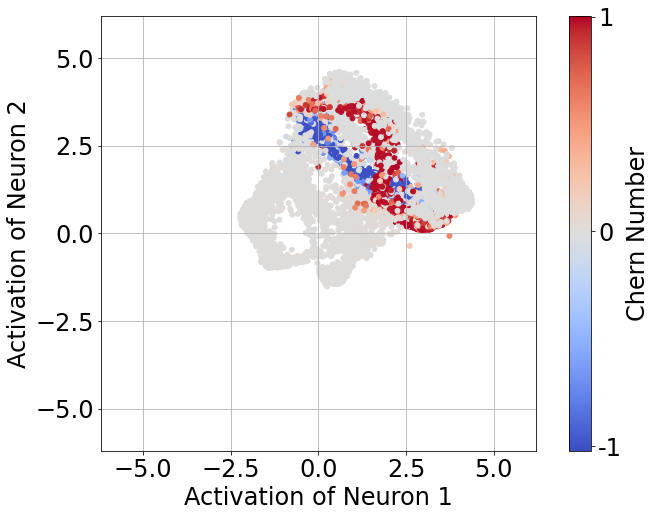

In [14]:
x = latent_space[:, 0]
y = latent_space[:, 1]
phases = parameter['phase']
freqs = parameter['freq']
theory_pred = theory_phase_diagram.get_theory_predictions(freqs, phases)

ax = plt.subplot()
ax.set_aspect('equal', 'box')
plt.scatter(x, y, 24, theory_pred, 'o', cmap='coolwarm', rasterized=True)
plt.xlim([-6.2, 6.2])
plt.ylim([-6.2, 6.2])
plt.yticks([-5, -2.5, 0, 2.5, 5])
cbar = plt.colorbar(ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['-1', '0', '1'])
cbar.ax.set_ylabel('Chern Number')
plt.xlabel('Activation of Neuron 1')
plt.ylabel('Activation of Neuron 2')
plt.grid()
#plt.savefig('plots/IIId/complete_bottleneck_theory_color.eps', bbox_inches='tight')
plt.show()

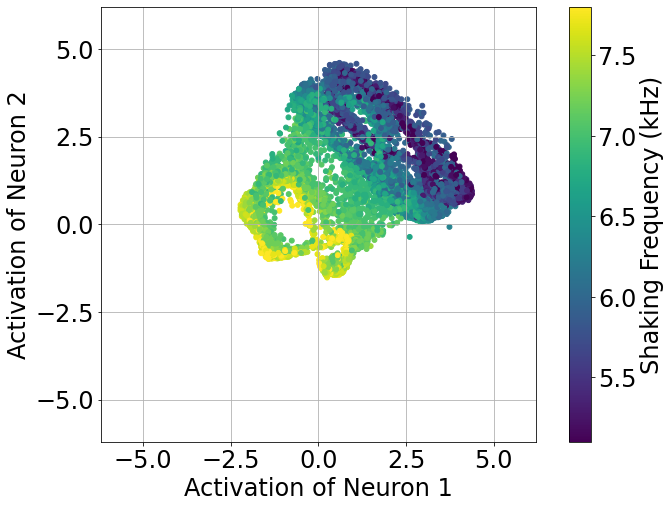

In [15]:
x = latent_space[:, 0]
y = latent_space[:, 1]
phases = parameter['phase']
freqs = parameter['freq']
theory_pred = theory_phase_diagram.get_theory_predictions(freqs, phases)

ax = plt.subplot()
ax.set_aspect('equal', 'box')
plt.scatter(x, y, 24, freqs, 'o', cmap='viridis', rasterized=True)
plt.xlim([-6.2, 6.2])
plt.ylim([-6.2, 6.2])
plt.yticks([-5, -2.5, 0, 2.5, 5])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Shaking Frequency (kHz)')
plt.xlabel('Activation of Neuron 1')
plt.ylabel('Activation of Neuron 2')
plt.grid()
#plt.savefig('plots/IIId/complete_bottleneck_freq_color.eps', bbox_inches='tight')
plt.show()

# Plot cut along a fixed shaking frequency
This figure is used in the appendix

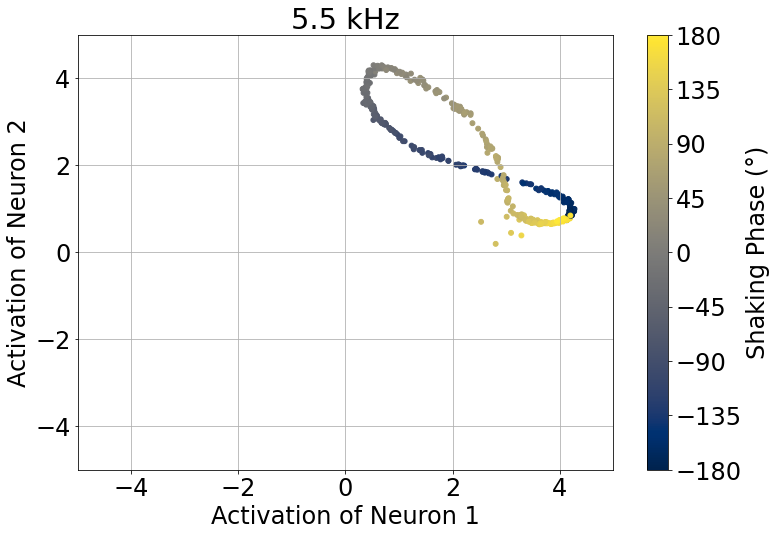

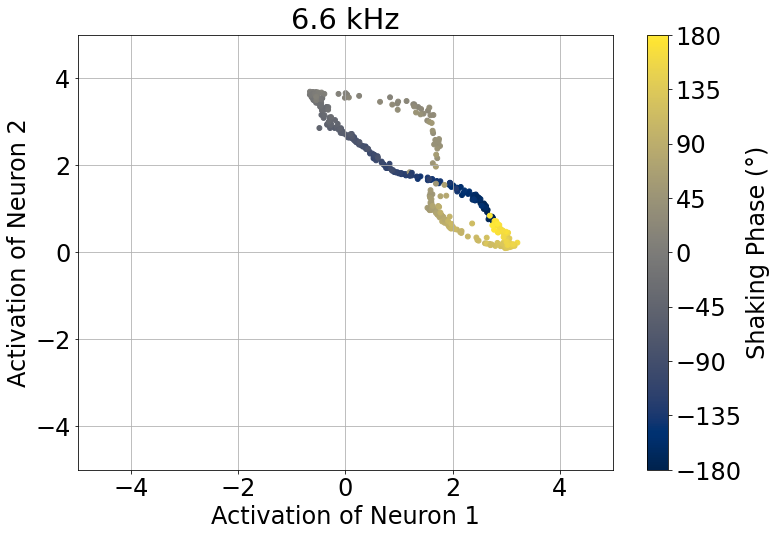

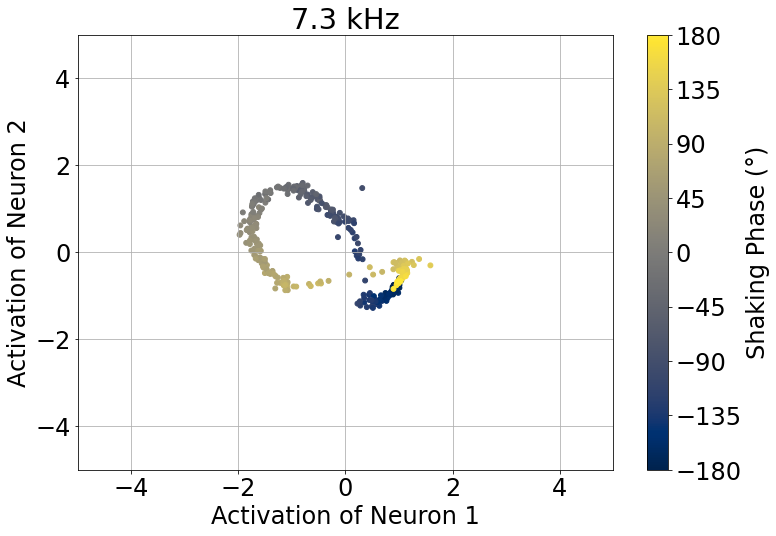

In [16]:
frequency_selection = [5.5, 6.6, 7.3]
for s_freq in frequency_selection:
    selection_map = parameter['freq'] == s_freq
    x = latent_space[selection_map, 0]
    y = latent_space[selection_map, 1]
    phases = parameter['phase'][selection_map]
    freqs = parameter['freq'][selection_map]

    plt.scatter(x, y, 24, phases, 'o', cmap='cividis', rasterized=True)
    plt.xlim([-5.0, 5.0])
    plt.ylim([-5.0, 5.0])
    cbar = plt.colorbar(ticks=phase_ticks)
    cbar.ax.set_ylabel('Shaking Phase (°)')
    plt.xlabel('Activation of Neuron 1')
    plt.ylabel('Activation of Neuron 2')
    plt.title('{} kHz'.format(s_freq))
    plt.grid()
    #plt.savefig('plots/IIId/freq_cut_{}.eps'.format(s_freq), bbox_inches='tight')
    plt.show()

# Analyse the bottleneck activations for fixed shaking phase cuts

In [17]:
def create_kmeans_clusters(X, freqs):
    kmeans = KMeans(n_clusters=3, random_state=1234, max_iter=500, n_init=1).fit(X)
    labels = kmeans.labels_
    inertia = kmeans.inertia_

    cluster_freq_cent = []
    for idx in range(3):
        sub_selection_map = labels == float(idx)
        cluster_freq_cent.append(np.mean(freqs[sub_selection_map]))
    
    low_class = np.squeeze(np.where(cluster_freq_cent == np.min(cluster_freq_cent)))
    mid_class = np.squeeze(np.where((cluster_freq_cent != np.min(cluster_freq_cent)) & (cluster_freq_cent != np.max(cluster_freq_cent))))
    high_class = np.squeeze(np.where(cluster_freq_cent == np.max(cluster_freq_cent)))
    
    ordered_labels = np.zeros(len(freqs))
    ordered_labels[labels == low_class] = 0
    ordered_labels[labels == mid_class] = 1
    ordered_labels[labels == high_class] = 2
    
    return ordered_labels

In [18]:
unique_phases = np.unique(parameter['phase'])

kmean_label = np.zeros(number_of_images, dtype=np.uint8)
for phase in unique_phases:
    selection_map = parameter['phase'] == phase
    freqs = parameter['freq'][selection_map]
    X = latent_space[selection_map, :]
    
    if phase < 0:
        labels = create_kmeans_clusters(X, freqs)
    else:
        labels = create_kmeans_clusters(X, freqs)
    kmean_label[selection_map] = labels

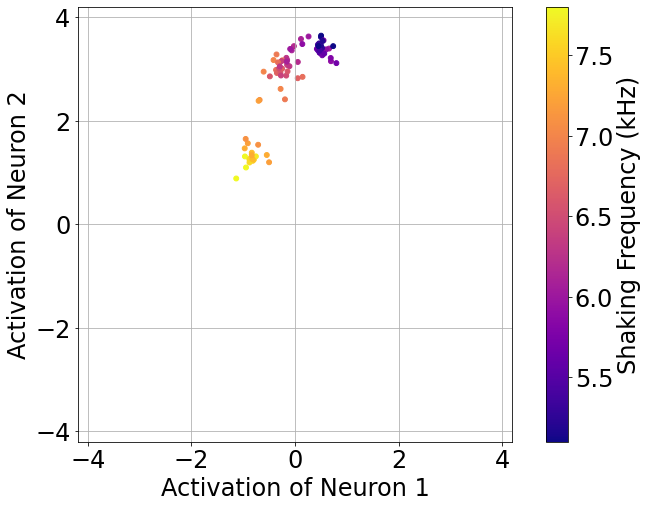

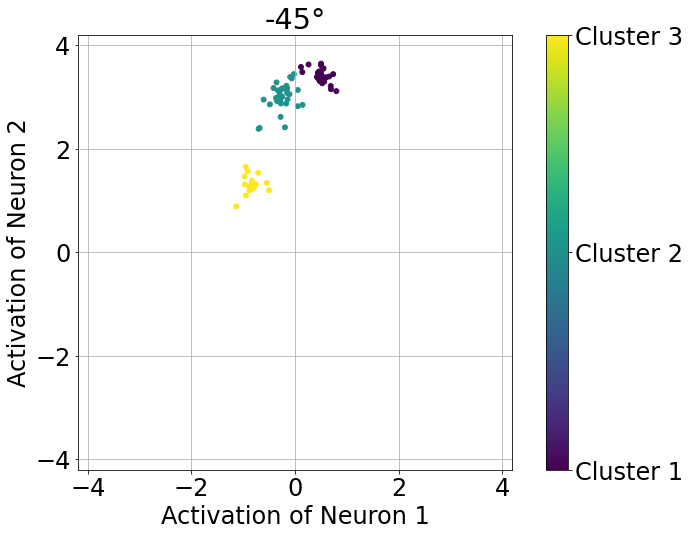

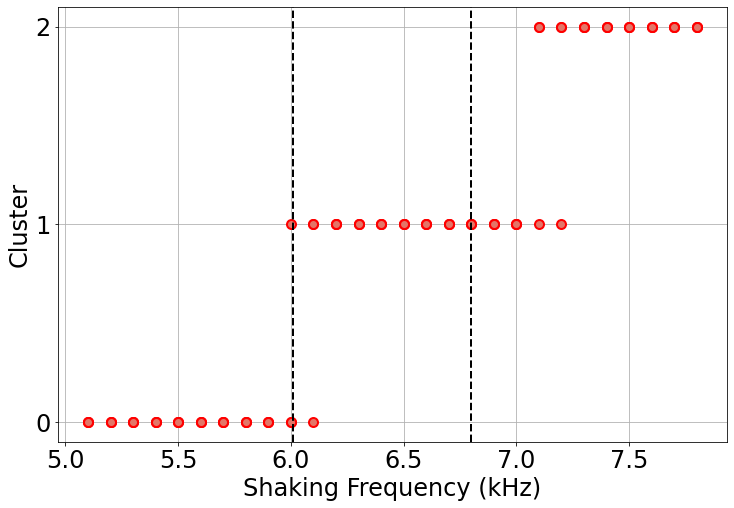

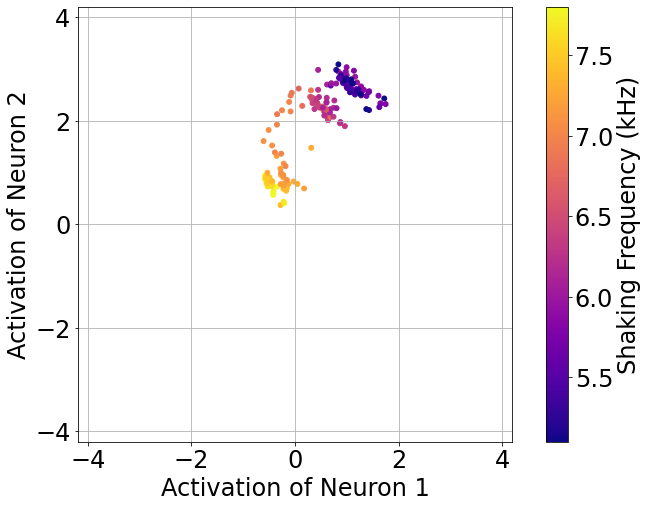

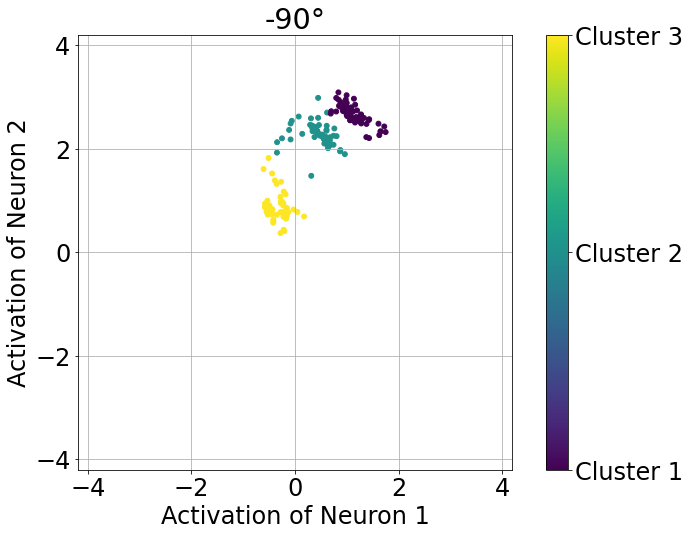

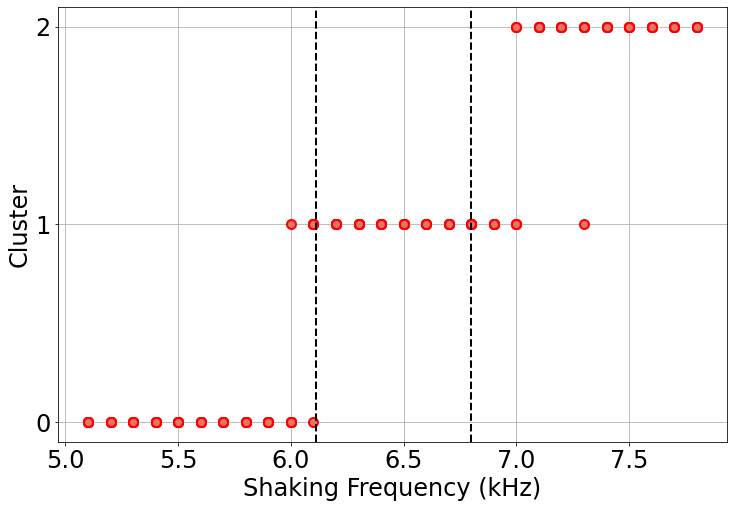

In [19]:
phase_selection = [-45, -90]
for s_phase in phase_selection:
    selection_map = parameter['phase'] == s_phase
    x = latent_space[selection_map, 0]
    y = latent_space[selection_map, 1]
    phases = parameter['phase'][selection_map]
    freqs = parameter['freq'][selection_map]

    ax = plt.subplot()
    ax.set_aspect('equal', 'box')
    plt.scatter(x, y, 24, freqs, 'o', cmap='plasma', rasterized=True)
    plt.xlim([-4.2, 4.2])
    plt.ylim([-4.2, 4.2])
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Shaking Frequency (kHz)')
    plt.xlabel('Activation of Neuron 1')
    plt.ylabel('Activation of Neuron 2')
    plt.yticks([-4, -2, 0, 2, 4])
    plt.grid()
    #plt.savefig('plots/IIId/phase_cut_{}_freq_color.eps'.format(s_phase), bbox_inches='tight')
    plt.show()
    
    k_mean_labels = kmean_label[selection_map]
    ax = plt.subplot()
    ax.set_aspect('equal', 'box')
    plt.scatter(x, y, 24, k_mean_labels, 'o', cmap='viridis', rasterized=True)
    plt.xlim([-4.2, 4.2])
    plt.ylim([-4.2, 4.2])
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
    plt.xlabel('Activation of Neuron 1')
    plt.ylabel('Activation of Neuron 2')
    plt.yticks([-4, -2, 0, 2, 4])
    plt.title('{}°'.format(s_phase))
    plt.grid()
    #plt.savefig('plots/IIId/phase_cut_{}_cluster_color.eps'.format(s_phase), bbox_inches='tight')
    plt.show()
    
    plt.plot(freqs, kmean_label[selection_map])
    plt.xlabel('Shaking Frequency (kHz)')
    plt.ylabel('Cluster')
    plt.yticks([0, 1, 2])
    try:
        lower_transition, upper_transition = theory_phase_diagram.get_theory_transitions(s_phase)
        plt.axvline(lower_transition, ls='--', marker=None, color='black', ms=0, linewidth=2)
        plt.axvline(upper_transition, ls='--', marker=None, color='black', ms=0, linewidth=2)
    except:
        print('No theory transition.')
    plt.grid()
    #plt.savefig('plots/IIId/phase_cut_{}_clusters.eps'.format(s_phase), bbox_inches='tight')
    plt.show()

## Haldane Phasediagram

In [20]:
unique_phases = np.unique(parameter['phase'])
unique_freqs = np.unique(parameter['freq'])

phase_diagram = []
for phase in unique_phases:
    selection_map = parameter['phase'] == phase
    freqs = parameter['freq'][selection_map]
    ordered_labels = kmean_label[selection_map]
    
    single_cut = []
    for freq in unique_freqs:
        # we do majority voting here
        votes = [np.sum(ordered_labels[freq == freqs] == 0),
                 np.sum(ordered_labels[freq == freqs] == 1),
                 np.sum(ordered_labels[freq == freqs] == 2)]
        single_cut.append(np.argmax(votes))
    phase_diagram.append(single_cut)
    
phase_diagram = np.array(phase_diagram)

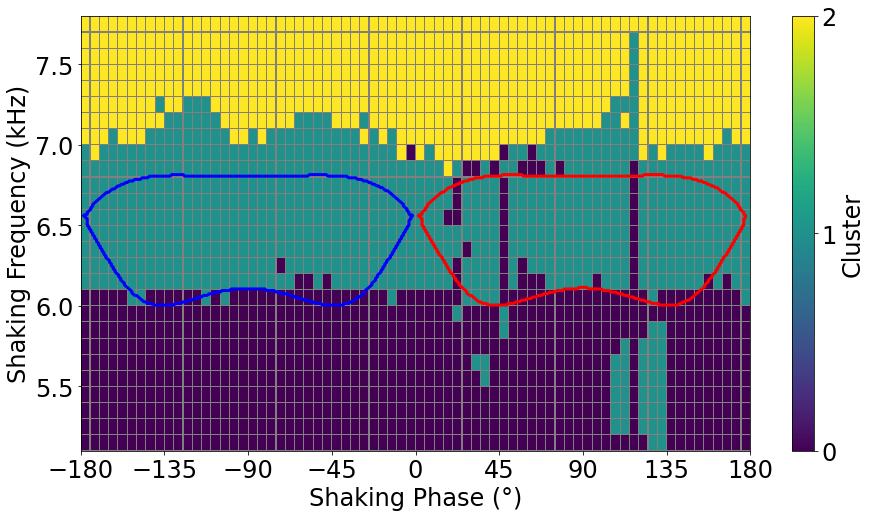

In [21]:
plt.figure(figsize= (15, 8))
plt.pcolormesh(unique_phases, unique_freqs, phase_diagram.T, cmap="viridis", rasterized=True,
               edgecolors='gray', linewidth=0.1)
plt.xticks(phase_ticks)
plt.xlabel('Shaking Phase (°)')
plt.ylabel('Shaking Frequency (kHz)')
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['0', '1', '2'])
cbar.ax.set_ylabel('Cluster')
plt.contour(theory_phase_diagram.phase, theory_phase_diagram.freq,
            np.round(theory_phase_diagram.chern_number.T),
            levels=[-0.5, 0.5], cmap="bwr")
plt.xlim([-180, 180])
plt.ylim([np.min(freqs), np.max(freqs)])
#plt.savefig('plots/IIId/haldane_kmeans.eps', bbox_inches='tight')
plt.show()